In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import string
import nltk
nltk.download('popular')
nltk.download('vader_lexicon')
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/kevinyu/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/kevinyu/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/kevinyu/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/kevinyu/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/kevinyu/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/kevinyu/nltk_data...
[nltk_data]    |   Package movie_reviews is already

In [2]:
yelpZip_fulldata = pd.read_pickle('../../data/processed/yelpZip_fulldata.pkl')

yelpZip_preprocessed = yelpZip_fulldata.copy()
yelpZip_preprocessed.head()

,userId,prodId,date,content,content_len,label,rating
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",36,-1,1.0
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,248,-1,1.0
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,50,-1,3.0
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,233,-1,5.0
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,152,-1,5.0


## Special cases

### 1. User 7129 has two exact same reviews

In [3]:
yelpZip_preprocessed[yelpZip_preprocessed['userId']==7129]

,userId,prodId,date,content,content_len,label,rating
2090,7129,9,2013-03-27,I was in Philly over the weekend for the NCAA ...,334,1,2.0
464915,7129,3876,2013-03-27,I was in Philly over the weekend for the NCAA ...,334,1,2.0


### 2. Below users have strange reviews

In [4]:
special_cases = [5569, 6151, 25015, 26895, 28864, 29815, 71392, 72469, 78076, 85684, 86744, 88926, 96603, 99825, 101445, 106986, 107131, 107770, 114654, 117074, 117672, 119889, 121353, 125486, 130537, 141126, 142004, 151582, 163441, 176100, 177079, 177285, 177838, 192258, 204801, 208785, 217435, 217529, 218179, 218464, 230086, 232622, 233175, 235114]

yelpZip_preprocessed[yelpZip_preprocessed['userId'].isin(special_cases)]

,userId,prodId,date,content,content_len,label,rating
526,5569,7,2013-02-02,-,1,1,4.0
1108,6151,9,2014-07-07,:),1,-1,4.0
22764,25015,151,2014-11-11,a,1,-1,5.0
25053,26895,176,2014-09-12,I,1,1,3.0
27779,28864,1700,2012-02-10,.,1,1,2.0
29073,29815,226,2014-09-16,!,1,1,5.0
95367,71392,867,2014-10-21,.,1,-1,1.0
97034,72469,3494,2010-01-21,:(,1,1,1.0
107159,78076,4493,2014-10-11,.,1,1,3.0
121220,85684,1097,2014-10-28,J,1,1,1.0


In [5]:
#yelpZip_preprocessed = yelpZip_preprocessed[~yelpZip_preprocessed['userId'].isin(special_cases)]

## Helper function

In [19]:
def get_similarity(vector):
    matrix = cosine_similarity(vector)
    np.fill_diagonal(matrix, 0)
    return matrix.mean(), matrix.max()

def add_average_review_similarity(x):
    userId = x['userId']
    average_similarity = review_dict[userId]['review_average_similarity']
    return average_similarity

def add_max_review_similarity(x):
    userId = x['userId']
    max_similarity = review_dict[userId]['review_max_similarity']
    return max_similarity

def add_review_per_day(x):
    userId = x['userId']
    date = x['date']
    review_count_today = review_dict[userId]['review_date'][date]
    return review_count_today

def add_rating_deviation(x):
    prodId = x['prodId']
    rating = x['rating']
    average_rating = product_dict[prodId]['average_rating']
    return abs(rating-average_rating)

def tokenize_content(x): 
    review = x['content']
    # remove punctuation
    review = review.translate(str.maketrans('', '', string.punctuation))
    # tokenize
    tokens = nltk.word_tokenize(review)
    # remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token.lower() for token in tokens if not token.lower() in stop_words]
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return lemmatized_tokens

def add_corpus(x):
    tokenize_content = x['tokenize_content']
    corpus = ' '.join([token for token in tokenize_content])
    return corpus

def nltk_sentiment(sentence):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

def count_cap_words(x):
    review = x['content']
    return len(re.findall(r'\b[A-Z]{2,}\b', review))

def count_digit_words(x):
    review = x['content']
    return len(re.findall(r'\b[0-9]{2,}\b', review))

def add_abs_compound(x):
    compound = x['compound']
    return abs(compound)

def add_length_deviation(x):
    origin_len = x['content_len']
    new_len = x['tokenize_content_len']
    return (origin_len-new_len)/(origin_len)
    

## Preprocessing

### 1. User's review similarity

In [36]:
user_ids = yelpZip_preprocessed["userId"].unique()
review_dict = dict()
strange_ids = []
since = time.time()

for i, user_id in enumerate(user_ids):
    yelpZip_preprocessed_demo = yelpZip_preprocessed[yelpZip_preprocessed['userId']==user_id].copy()
    data = list(yelpZip_preprocessed_demo['content'])
    review_date = yelpZip_preprocessed_demo.groupby('date').size().to_dict()
    
    try:
#         count_vectorizer = CountVectorizer()
#         vector_matrix = count_vectorizer.fit_transform(data)
#         vector_matrix_array = vector_matrix.toarray()

        tfidf_vectorizer = TfidfVectorizer()
        vector_matrix = tfidf_vectorizer.fit_transform(data)
        vector_matrix_array = vector_matrix.toarray()

        average_similarity, max_similarity = get_similarity(vector_matrix_array)
        
        review_dict[user_id] = {
            'review_average_similarity': average_similarity,
            'review_max_similarity': max_similarity,
            'review_count': len(data),
            'review_date': review_date
        }
    except:
        strange_ids.append(user_id)
        review_dict[user_id] = {
            'review_average_similarity': 0,
            'review_max_similarity': 0,
            'review_count': len(data),
            'review_date': review_date
        }
        
time_elapsed = time.time() - since
print(f'Calculation complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Calculation complete in 10.0m 26.61124539375305s


In [38]:
yelpZip_preprocessed['average_review_similarity'] = yelpZip_preprocessed.apply(add_average_review_similarity, axis=1)
yelpZip_preprocessed['max_review_similarity'] = yelpZip_preprocessed.apply(add_max_review_similarity, axis=1)
yelpZip_preprocessed.head()

,userId,prodId,date,content,content_len,label,rating,average_review_similarity,max_review_similarity,review_count_today,...,tokenize_content_len,corpus,neg,neu,pos,compound,cap_word_count,digit_word_count,absolute_compound,length_deviation
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",36,-1,1.0,0.000000,0.0000,1,...,17,drink bad hot chocolate watered latte burnt ta...,0.513,0.487,0.000,-0.9287,0,0,0.9287,0.527778
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,248,-1,1.0,0.000000,0.0000,1,...,122,worst experience ive ever casual coffeelight f...,0.195,0.584,0.221,0.6128,0,2,0.6128,0.508065
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,50,-1,3.0,0.162733,0.3298,1,...,24,located site old spruce st video mild cofee go...,0.000,0.610,0.390,0.9153,1,0,0.9153,0.520000
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,233,-1,5.0,0.000000,0.0000,1,...,129,enjoyed coffee breakfast twice toast recent vi...,0.016,0.614,0.370,0.9954,1,0,0.9954,0.446352
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,152,-1,5.0,0.000000,0.0000,1,...,79,love toast food choice fantastic love serve br...,0.000,0.518,0.482,0.9945,0,0,0.9945,0.480263


### 2. User's reviews count per date

In [9]:
yelpZip_preprocessed['review_count_today'] = yelpZip_preprocessed.apply(add_review_per_day, axis=1)
yelpZip_preprocessed.head()

,userId,prodId,date,content,content_len,label,rating,average_review_similarity,max_review_similarity,review_count_today
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",36,-1,1.0,0,0,1
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,248,-1,1.0,0,0,1
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,50,-1,3.0,0,0,1
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,233,-1,5.0,0,0,1
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,152,-1,5.0,0,0,1


### 3. User's rating deviation

In [10]:
product_ids = yelpZip_preprocessed["prodId"].unique()
product_dict = dict()
since = time.time()

for i, product_id in enumerate(product_ids):
    yelpZip_preprocessed_demo = yelpZip_preprocessed[yelpZip_preprocessed['prodId']==product_id].copy()
    average_rating = yelpZip_preprocessed_demo['rating'].mean()
    
    product_dict[product_id] = {
        'average_rating': average_rating
    }

        
time_elapsed = time.time() - since
print(f'Calculation complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Calculation complete in 0.0m 4.238510370254517s


In [11]:
yelpZip_preprocessed['rating_deviation'] = yelpZip_preprocessed.apply(add_rating_deviation, axis=1)
yelpZip_preprocessed.head()

,userId,prodId,date,content,content_len,label,rating,average_review_similarity,max_review_similarity,review_count_today,rating_deviation
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",36,-1,1.0,0,0,1,2.613636
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,248,-1,1.0,0,0,1,2.613636
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,50,-1,3.0,0,0,1,0.613636
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,233,-1,5.0,0,0,1,1.386364
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,152,-1,5.0,0,0,1,1.386364


### 4. Tokenize review sentences

### Example

In [12]:
sentence = yelpZip_preprocessed.iloc[0]['content']

print(sentence)
print()

# remove punctuation
sentence = sentence.translate(str.maketrans('', '', string.punctuation))

print(sentence)
print()

print(sentence.split())
print(len(sentence.split()))
print()

# tokenize
tokens = nltk.word_tokenize(sentence)

print(tokens)
print(len(tokens))
print()

# remove stop words
stop_words = set(stopwords.words('english'))
filtered_tokens = [token.lower() for token in tokens if not token.lower() in stop_words]

print(filtered_tokens)
print(len(filtered_tokens))
print()


# lemmatize
lemmatizer = WordNetLemmatizer()
lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
print(lemmatized_tokens)
print(len(lemmatized_tokens))

Drinks were bad, the hot chocolate was watered down and the latte had a burnt taste to it. The food was also poor quality, but the service was the worst part, their cashier was very rude.

Drinks were bad the hot chocolate was watered down and the latte had a burnt taste to it The food was also poor quality but the service was the worst part their cashier was very rude

['Drinks', 'were', 'bad', 'the', 'hot', 'chocolate', 'was', 'watered', 'down', 'and', 'the', 'latte', 'had', 'a', 'burnt', 'taste', 'to', 'it', 'The', 'food', 'was', 'also', 'poor', 'quality', 'but', 'the', 'service', 'was', 'the', 'worst', 'part', 'their', 'cashier', 'was', 'very', 'rude']
36

['Drinks', 'were', 'bad', 'the', 'hot', 'chocolate', 'was', 'watered', 'down', 'and', 'the', 'latte', 'had', 'a', 'burnt', 'taste', 'to', 'it', 'The', 'food', 'was', 'also', 'poor', 'quality', 'but', 'the', 'service', 'was', 'the', 'worst', 'part', 'their', 'cashier', 'was', 'very', 'rude']
36

['drinks', 'bad', 'hot', 'chocolate

### Process

In [13]:
since = time.time()

yelpZip_preprocessed['tokenize_content'] = yelpZip_preprocessed.apply(tokenize_content, axis=1)

time_elapsed = time.time() - since
print(f'Calculation complete in {time_elapsed // 60}m {time_elapsed % 60}s')

yelpZip_preprocessed.head()

Calculation complete in 6.0m 38.88021111488342s


,userId,prodId,date,content,content_len,label,rating,average_review_similarity,max_review_similarity,review_count_today,rating_deviation,tokenize_content
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",36,-1,1.0,0,0,1,2.613636,"[drink, bad, hot, chocolate, watered, latte, b..."
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,248,-1,1.0,0,0,1,2.613636,"[worst, experience, ive, ever, casual, coffeel..."
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,50,-1,3.0,0,0,1,0.613636,"[located, site, old, spruce, st, video, mild, ..."
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,233,-1,5.0,0,0,1,1.386364,"[enjoyed, coffee, breakfast, twice, toast, rec..."
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,152,-1,5.0,0,0,1,1.386364,"[love, toast, food, choice, fantastic, love, s..."


In [14]:
yelpZip_preprocessed['tokenize_content_len'] = yelpZip_preprocessed['tokenize_content'].str.len()
yelpZip_preprocessed['corpus'] = yelpZip_preprocessed.apply(add_corpus, axis=1)

yelpZip_preprocessed.head()

,userId,prodId,date,content,content_len,label,rating,average_review_similarity,max_review_similarity,review_count_today,rating_deviation,tokenize_content,tokenize_content_len,corpus
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",36,-1,1.0,0,0,1,2.613636,"[drink, bad, hot, chocolate, watered, latte, b...",17,drink bad hot chocolate watered latte burnt ta...
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,248,-1,1.0,0,0,1,2.613636,"[worst, experience, ive, ever, casual, coffeel...",122,worst experience ive ever casual coffeelight f...
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,50,-1,3.0,0,0,1,0.613636,"[located, site, old, spruce, st, video, mild, ...",24,located site old spruce st video mild cofee go...
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,233,-1,5.0,0,0,1,1.386364,"[enjoyed, coffee, breakfast, twice, toast, rec...",129,enjoyed coffee breakfast twice toast recent vi...
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,152,-1,5.0,0,0,1,1.386364,"[love, toast, food, choice, fantastic, love, s...",79,love toast food choice fantastic love serve br...


In [15]:
since = time.time()

nltk_results = [nltk_sentiment(row) for row in yelpZip_preprocessed['corpus']]
results_df = pd.DataFrame(nltk_results)

time_elapsed = time.time() - since
print(f'Calculation complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Calculation complete in 51.0m 31.305619478225708s


In [16]:
yelpZip_preprocessed = yelpZip_preprocessed.join(results_df)
yelpZip_preprocessed.head()

,userId,prodId,date,content,content_len,label,rating,average_review_similarity,max_review_similarity,review_count_today,rating_deviation,tokenize_content,tokenize_content_len,corpus,neg,neu,pos,compound
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",36,-1,1.0,0,0,1,2.613636,"[drink, bad, hot, chocolate, watered, latte, b...",17,drink bad hot chocolate watered latte burnt ta...,0.513,0.487,0.000,-0.9287
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,248,-1,1.0,0,0,1,2.613636,"[worst, experience, ive, ever, casual, coffeel...",122,worst experience ive ever casual coffeelight f...,0.195,0.584,0.221,0.6128
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,50,-1,3.0,0,0,1,0.613636,"[located, site, old, spruce, st, video, mild, ...",24,located site old spruce st video mild cofee go...,0.000,0.610,0.390,0.9153
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,233,-1,5.0,0,0,1,1.386364,"[enjoyed, coffee, breakfast, twice, toast, rec...",129,enjoyed coffee breakfast twice toast recent vi...,0.016,0.614,0.370,0.9954
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,152,-1,5.0,0,0,1,1.386364,"[love, toast, food, choice, fantastic, love, s...",79,love toast food choice fantastic love serve br...,0.000,0.518,0.482,0.9945


In [20]:
yelpZip_preprocessed['cap_word_count'] = yelpZip_preprocessed.apply(count_cap_words, axis=1)
yelpZip_preprocessed['digit_word_count'] = yelpZip_preprocessed.apply(count_digit_words, axis=1)
yelpZip_preprocessed['absolute_compound'] = yelpZip_preprocessed.apply(add_abs_compound, axis=1)
yelpZip_preprocessed['length_deviation'] = yelpZip_preprocessed.apply(add_length_deviation, axis=1)

yelpZip_preprocessed.head()

,userId,prodId,date,content,content_len,label,rating,average_review_similarity,max_review_similarity,review_count_today,...,tokenize_content_len,corpus,neg,neu,pos,compound,cap_word_count,digit_word_count,absolute_compound,length_deviation
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",36,-1,1.0,0,0,1,...,17,drink bad hot chocolate watered latte burnt ta...,0.513,0.487,0.000,-0.9287,0,0,0.9287,0.527778
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,248,-1,1.0,0,0,1,...,122,worst experience ive ever casual coffeelight f...,0.195,0.584,0.221,0.6128,0,2,0.6128,0.508065
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,50,-1,3.0,0,0,1,...,24,located site old spruce st video mild cofee go...,0.000,0.610,0.390,0.9153,1,0,0.9153,0.520000
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,233,-1,5.0,0,0,1,...,129,enjoyed coffee breakfast twice toast recent vi...,0.016,0.614,0.370,0.9954,1,0,0.9954,0.446352
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,152,-1,5.0,0,0,1,...,79,love toast food choice fantastic love serve br...,0.000,0.518,0.482,0.9945,0,0,0.9945,0.480263


In [40]:
yelpZip_preprocessed.to_pickle('../../data/processed/yelpZip_preprocessed.pkl')

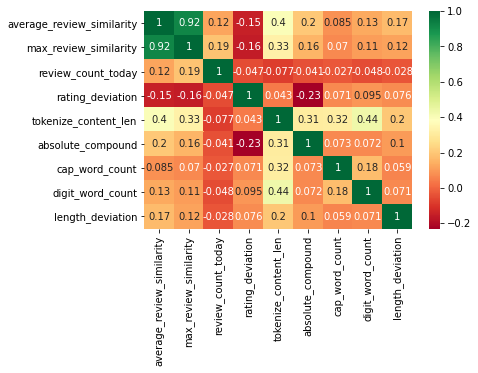

In [39]:
import seaborn as sns

#correlation matrix
final_corr_data = sns.heatmap(yelpZip_preprocessed[['average_review_similarity', 'max_review_similarity', 'review_count_today', 'rating_deviation', 'tokenize_content_len',
           'absolute_compound', 'cap_word_count', 'digit_word_count', 'length_deviation']].corr(),annot=True,cmap="RdYlGn")